In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv("obesity_prediction.csv")

In [3]:
df

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [4]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


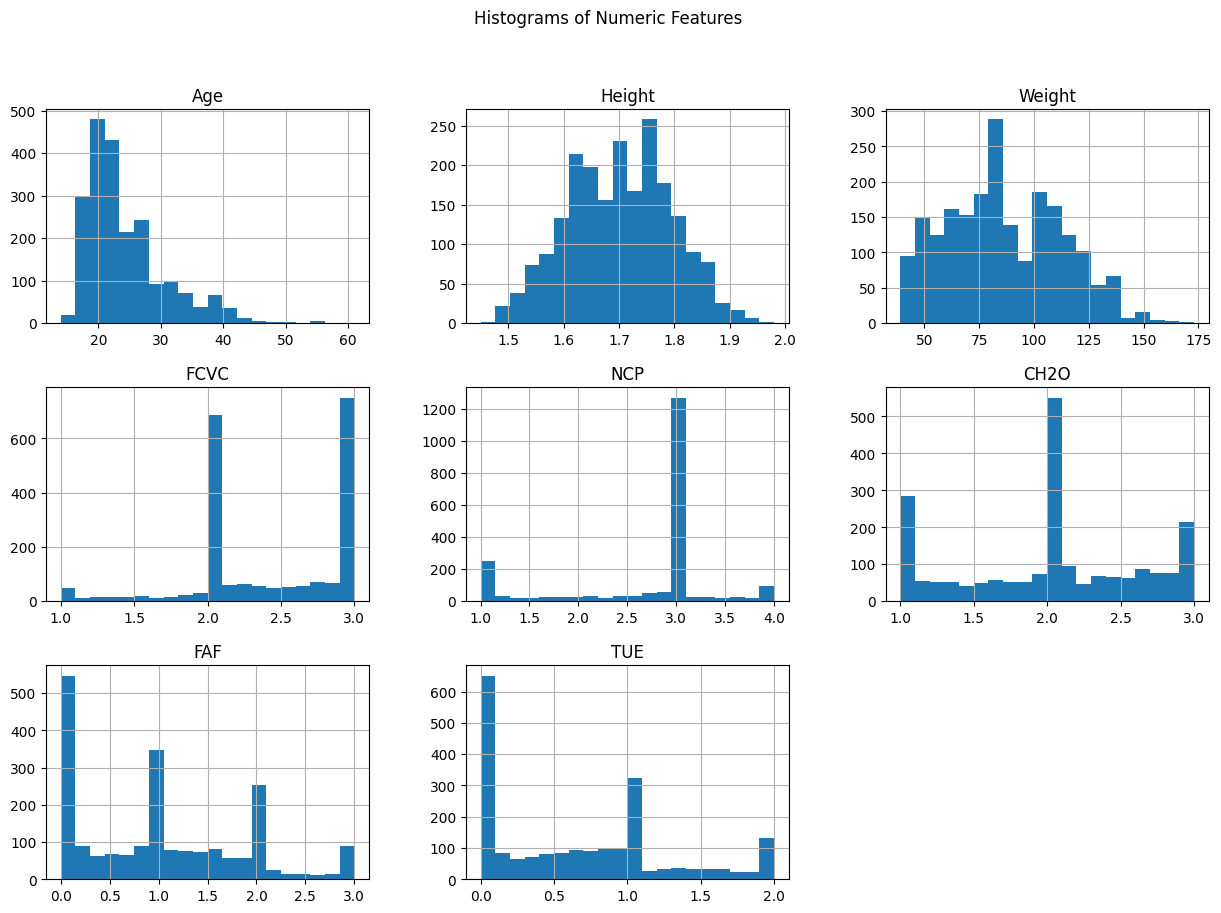

In [5]:
numeric_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
df[numeric_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Features")
plt.show()


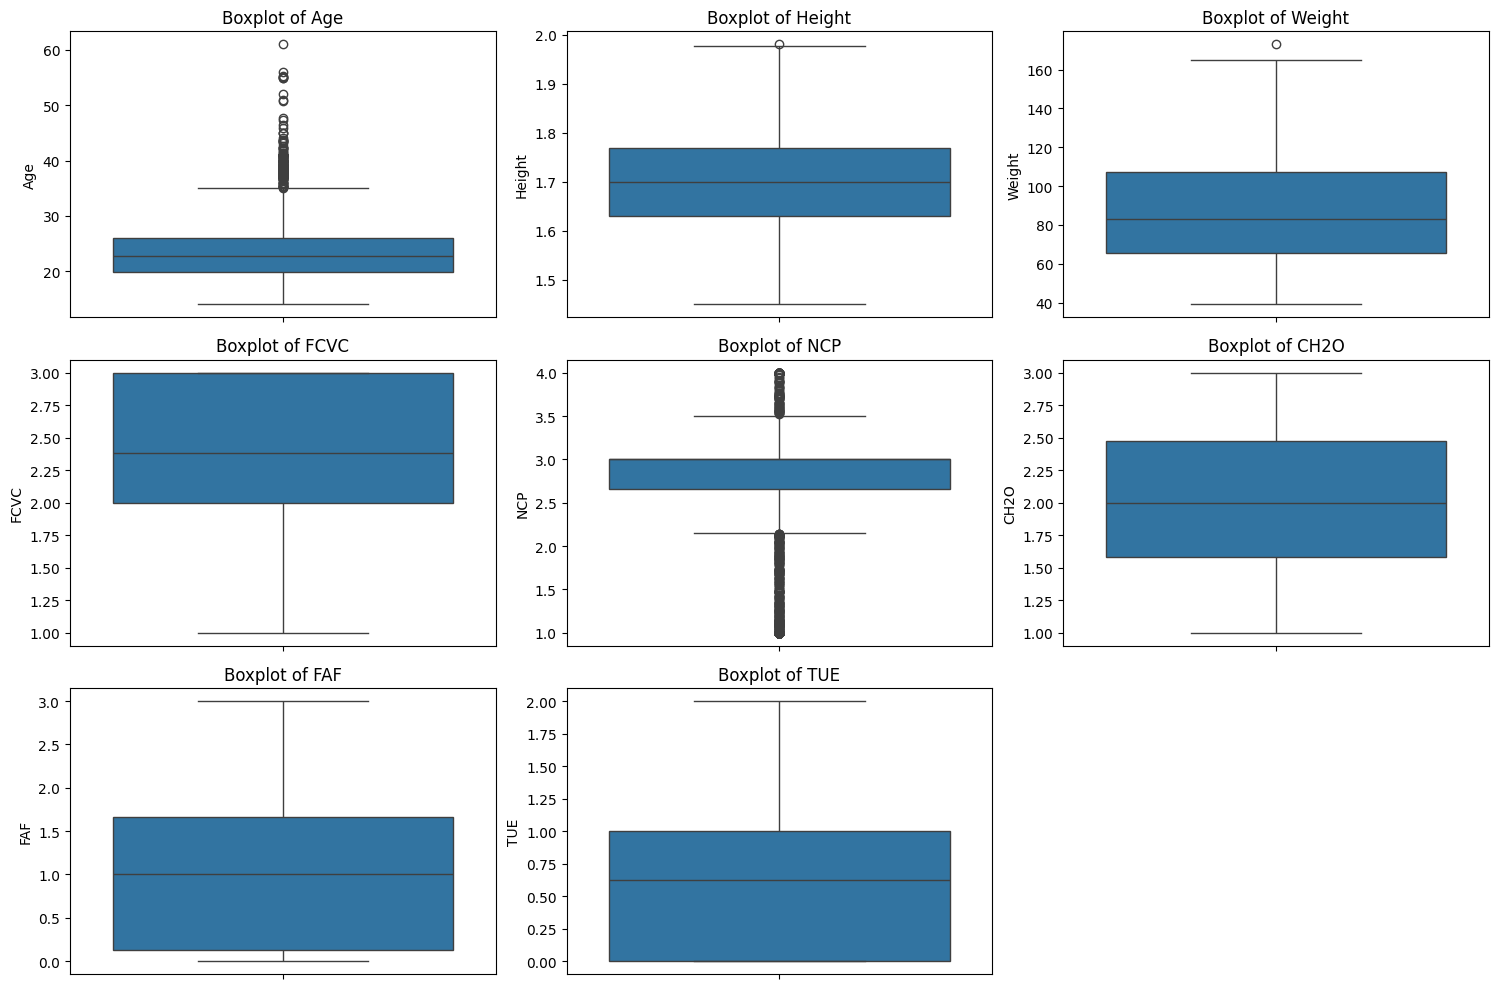

In [6]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


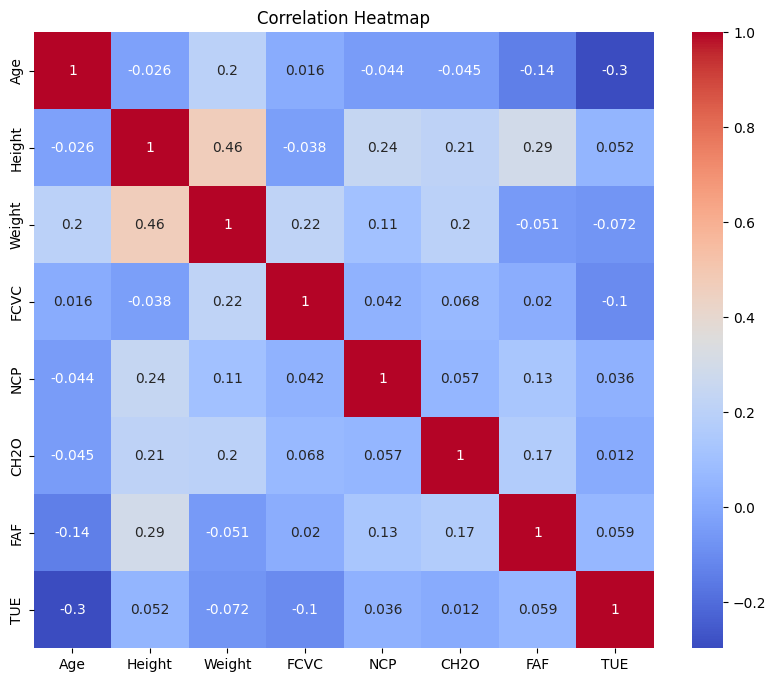

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [8]:
df=df.loc[df['Obesity'] !='Insufficient_Weight']

In [9]:
df = pd.get_dummies(df, columns = ["Gender", "family_history", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"])
df

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Obesity,Gender_Female,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.000000,1.620000,64.000000,2.0,3.0,2.000000,0.000000,1.000000,Normal_Weight,True,...,False,False,False,False,True,False,False,False,True,False
1,21.000000,1.520000,56.000000,3.0,3.0,3.000000,3.000000,0.000000,Normal_Weight,True,...,True,False,False,True,False,False,False,False,True,False
2,23.000000,1.800000,77.000000,2.0,3.0,2.000000,2.000000,1.000000,Normal_Weight,False,...,False,False,True,False,False,False,False,False,True,False
3,27.000000,1.800000,87.000000,3.0,3.0,2.000000,2.000000,0.000000,Overweight_Level_I,False,...,False,False,True,False,False,False,False,False,False,True
4,22.000000,1.780000,89.800000,2.0,1.0,2.000000,0.000000,0.000000,Overweight_Level_II,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,1.710730,131.408528,3.0,3.0,1.728139,1.676269,0.906247,Obesity_Type_III,True,...,False,False,False,True,False,False,False,False,True,False
2107,21.982942,1.748584,133.742943,3.0,3.0,2.005130,1.341390,0.599270,Obesity_Type_III,True,...,False,False,False,True,False,False,False,False,True,False
2108,22.524036,1.752206,133.689352,3.0,3.0,2.054193,1.414209,0.646288,Obesity_Type_III,True,...,False,False,False,True,False,False,False,False,True,False
2109,24.361936,1.739450,133.346641,3.0,3.0,2.852339,1.139107,0.586035,Obesity_Type_III,True,...,False,False,False,True,False,False,False,False,True,False


LogisticRegression Model

In [10]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'saga'],
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [500, 1000, 2000]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'C': 100, 'max_iter': 500, 'solver': 'newton-cg'}
Training Accuracy: 0.9720
Test Accuracy: 0.9529
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.96      0.93      0.95        87
     Obesity_Type_I       0.95      0.96      0.96       104
    Obesity_Type_II       0.99      0.96      0.97       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.89      0.92      0.91        92
Overweight_Level_II       0.91      0.94      0.92        78

           accuracy                           0.95       552
          macro avg       0.95      0.95      0.95       552
       weighted avg       0.95      0.95      0.95       552


Confusion Matrix:
[[ 81   0   0   0   6   0]
 [  0 100   1   0   0   3]
 [  0   4  96   0   0   0]
 [  

RandomForestClassifier

In [11]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

importances = best_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training Accuracy: 1.0000
Test Accuracy: 0.9547
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.84      0.97      0.90        87
     Obesity_Type_I       0.98      0.97      0.98       104
    Obesity_Type_II       1.00      0.99      0.99       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.98      0.87      0.92        92
Overweight_Level_II       0.94      0.92      0.93        78

           accuracy                           0.95       552
          macro avg       0.96      0.95      0.95       552
       weighted avg       0.96      0.95      0.96       552


Confusion Matrix:
[[ 84   0   0   0   1   2]
 [  1 101   0   0   

K-Nearest Kneighbour (KNN)

In [12]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Training Accuracy: 1.0000
Test Accuracy: 0.9366
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.93      0.79      0.86        87
     Obesity_Type_I       0.96      0.96      0.96       104
    Obesity_Type_II       0.99      1.00      1.00       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.87      0.92      0.89        92
Overweight_Level_II       0.86      0.92      0.89        78

           accuracy                           0.94       552
          macro avg       0.93      0.93      0.93       552
       weighted avg       0.94      0.94      0.94       552


Confusion Matrix:
[[ 69   0   0   0  11   7]
 [  0 100   1   0   0   3]
 [  0   0 100   0

Gradient Boosting (XGBoost)

In [13]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

importance = best_model.get_booster().get_score(importance_type='gain')
feature_importances = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (Gain):")
print(feature_importances)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Training Accuracy: 1.0000
Test Accuracy: 0.9783
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.98      0.98      0.98        87
     Obesity_Type_I       0.98      1.00      0.99       104
    Obesity_Type_II       1.00      0.99      0.99       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.96      0.93      0.95        92
Overweight_Level_II       0.95      0.96      0.96        78

           accuracy                           0.98       552
          macro avg       0.98      0.98      0.98       552
       weighted avg       0.98      0.98      0.98       552


Confusion Matrix:
[[ 85   0   0   0   2   0]
 [  0

Multi-layer Perceptron (MLP - Neural Network)

In [14]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'adam'}
Training Accuracy: 1.0000
Test Accuracy: 0.9656
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.91      0.99      0.95        87
     Obesity_Type_I       0.99      0.98      0.99       104
    Obesity_Type_II       1.00      0.99      0.99       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.95      0.87      0.91        92
Overweight_Level_II       0.94      0.96      0.95        78

           accuracy                           0.97       552
          macro avg       0.96      0.97      0.96       552
       weighted avg       0.97      0.97      0.97       552


Confusion Matrix:
[[ 86   0  

Support Vector Machine (SVM)

In [15]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

numerical_inputs = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_scaled = scaler.fit_transform(X_train[numerical_inputs])

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

joblib.dump(best_model, 'svm_obesity_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_train.columns.tolist(), 'feature_names.pkl')
print("Model saved as svm_obesity_model.pkl")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Training Accuracy: 0.9860
Test Accuracy: 0.9710
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.96      0.99      0.97        87
     Obesity_Type_I       0.98      0.98      0.98       104
    Obesity_Type_II       1.00      0.99      0.99       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.97      0.91      0.94        92
Overweight_Level_II       0.91      0.95      0.93        78

           accuracy                           0.97       552
          macro avg       0.97      0.97      0.97       552
       weighted avg       0.97      0.97      0.97       552


Confusion Matrix:
[[ 86   0   0   0   1   0]
 [  0 102   0   0   0   2]
 [  0   1  99   0   0   0]
 [  0  